## PUT BANNER HERE 

# Twitter Sentiment Analysis
Authors: Anita Camlic, Dermot O'Brien, Dermot Holcombe
______________________________________________________________________________________________________

## Overview 
Apple wants to be able to understand their users. Since product reviews can have bias, we turned to Twitter. Twitter is a public service for friends, family, and coworkers to communicate and stay connected through the exchange of quick, frequent messages. People post Tweets, which may contain photos, videos, links, and text. These messages are posted to your profile, sent to your followers, and are searchable on Twitter search. 
We are using a dataset with tweets from the 2016 South by Southwest music festival. These tweets are labeled by sentiment (Positive, Neutral, Negative). Each row in the data provides relavant information about the content in each tweet. We used this dataset along with natural language processing techniques to predict tweet sentiment about Apple products and the brand itself.  

## Business Problem

The Apple Product team is constantly looking for changes they can implement to keep users happy. We were asked by Apple's Product team to create a model that can predict the sentiment of a tweet based on it's content. This model will categorize tweets as either positive or negative.

After the tweets are categorized, the Apple Product team can take a look at our words/bigrams with the highest TF-IDF average, and use that to inspire changes in certain products. Or, they can take a look at the negative tweets and the direct complaints that users are making on Twitter. These complaints and statements can then be used to make informed changes to products that users are unhappy about. This model will act as a general filter for finding tweets to provide insight on places of improvement.

In turn, this will allow Apple to better serve their users. It will give them the opportunity to make changes to products, that will hopefully decrease the amount of complaints and increase the positive viewpoints of the Apple and it's products.

## Data Overview

The original dataset contains 3 columns titled 'tweet_text', 'emotion_in_tweet_is_directed_at', and 'is_there_an_emotion_directed_at_a_brand_or_product'. The column 'tweet_text' contains individual tweet content as a string and was renamed 'tweet' for easier understanding. The column 'emotion_in_tweet_is_directed_at' contains strings representing the subject that the tweet is discussing and was renamed 'subject' for simplification. The column 'is_there_an_emotion_directed_at_a_brand_or_product' contains strings representing the percieved emotion being conveyed in the tweet. This column was renamed for 'emotion' for simplification.  

## Data Understanding
In this section, we are going to explore the dataset with visual analysis and then take a deeper dive into the variables with some visualizations. We are expecting to find some missing values and mislabeled data that we can clean later on.

#### Import Data and Create Dataframe

In [94]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [95]:
# use this do download stopwords if you haven't done this before - only needs to be done once
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [96]:
# loading in dataframe, using special encoder parameter to save it correctly and without errors
df = pd.read_csv('twitter_data.csv',encoding= 'unicode_escape')

In [98]:
# renaming the columns for simplicity purposes
df = df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "subject", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})

### Exploratory Data Analysis (EDA)

In [99]:
# Check rows and columns
df.shape

(9093, 3)

In [100]:
# See what each row looks like
df.head()

,tweet,subject,emotion
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [105]:
# See what an example tweet looks like 
df['tweet'][0],df['tweet'][2],df['tweet'][4]

('.@wesley83 I have a 3G iPhone. After 3 hrs tweeting at #RISE_Austin, it was dead!  I need to upgrade. Plugin stations at #SXSW.',
 '@swonderlin Can not wait for #iPad 2 also. They should sale them down at #SXSW.',
 "@sxtxstate great stuff on Fri #SXSW: Marissa Mayer (Google), Tim O'Reilly (tech books/conferences) &amp; Matt Mullenweg (Wordpress)")

In [106]:
# Check descriptive statistics of numeric columns
df.describe()

,tweet,subject,emotion
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [114]:
# looking at the spread of subjects in our data
df['subject'].value_counts(normalize=True)

iPad                               0.287451
Apple                              0.200851
iPad or iPhone App                 0.142814
Google                             0.130659
iPhone                             0.090246
Other Google product or service    0.089031
Android App                        0.024613
Android                            0.023701
Other Apple product or service     0.010635
Name: subject, dtype: float64

In [115]:
# looking at the spread of emotions in our data
df['emotion'].value_counts(normalize=True)

No emotion toward brand or product    0.592654
Positive emotion                      0.327505
Negative emotion                      0.062686
I can't tell                          0.017156
Name: emotion, dtype: float64

In [116]:
# Check for NaN's
df.isna().sum()

tweet         1
subject    5802
emotion       0
dtype: int64

## Data Preparation
Here we prepare our data to be modeled

In [117]:
# Here we are converting all the tweets to lowercase, so we don't run in to issues in the future
df['tweet'] = df['tweet'].str.lower()

Here, we are segmenting our data so that it only includes Negative or Positive emotions.We will call this new dataframe 'df_binary'. We are starting with a binary classification at first, and if we have time we will revisit multiclass classification.

In [118]:
# Creating binary class dataframe
df_binary = df.loc[(df['emotion'] == 'Positive emotion' ) | (df['emotion'] == 'Negative emotion' )]

We are now going to assign numeric values to the emotion. We are making the positive class (1) represent tweets with negative sentiment. We are making the negative class (0) represent tweets with positive sentiment. This is a little confusing, however we are doing this so that all of our metrics are focused on the positive class. The tweets we want to ensure classification on our negative tweets. This is because the negative tweets represent areas of improvement for Apple. So, we want to ensure all of the negative tweets are classified correctly, so we can create a more streamlined application process of our model.  

In [119]:
# Relabeling the content of the emotion column
df_binary.loc[df_binary['emotion'] == 'Positive emotion' , 'emotion_label'] = 0
df_binary.loc[df_binary['emotion'] == 'Negative emotion' , 'emotion_label'] = 1

C:\Users\User\anaconda3_1\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\User\anaconda3_1\envs\learn-env\lib\site-packages\pandas\core\indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


Next, we are creating a column named 'company'. This will represent the company the tweet is discussing. 


We do this by writing a function named label_brand that looks at the subject column, and based on the content of that column, will label the company column as either Apple or Google. Next, we take care of the null values in the subject column. If a row has a null value in the subject column, then we look for keywords in tweets, and labels the company accordingly. 

For example, if the tweet contains the words apple, iphone, ipad or itunes, it will be labeled as 'Apple'. On the flip side, if the tweet contains words like google or android, it will be labaled as 'Google. This makes it easier to tell which brand the tweet is targeting. It also decreases the complexity of the subject column. We now have only two labels: Apple and Google, instead of the previous 8. 

In [120]:
# function to label new column based on the product category 

def label_brand(row):
    if row['subject'] == 'iPad':
        return 'Apple'
    elif row['subject'] == 'Apple':
        return 'Apple'
    elif row['subject'] == 'iPad or iPhone App':
        return 'Apple'
    elif row['subject'] == 'iPhone':
        return 'Apple'
    elif row['subject'] == 'Other Apple product or service':
        return 'Apple'
    elif row['subject'] == 'Google':
        return 'Google'
    elif row['subject'] == 'Other Google product or service':
        return 'Google'
    elif row['subject'] == 'Android App':
        return 'Google'
    elif row['subject'] == 'Android':
        return 'Google'
    elif row['subject'] == np.nan: 
        return np.nan

In [121]:
# Applying label_brand to all rows in df_binary
df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)

<ipython-input-121-5e3ea6029349>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)


In [122]:
# Creating words to look for in tweets to label company accordingly
apple_words = ['apple','ipad','iphone','itunes']
google_words = ['google','android']

In [124]:
# Creating values for company column based on tweet content
df_binary.loc[(df_binary['subject'].isna()) &
              (df_binary['tweet'].str.contains('|'.join(apple_words))),'company'] = 'Apple'

In [125]:
# Creating values for company column based on tweet content
df_binary.loc[(df_binary['subject'].isna()) &
              (df_binary['tweet'].str.contains('|'.join(google_words))),'company'] = 'Google'

In [127]:
# We drop the remaining 11 rows with nulls in the company column
df_binary.dropna(subset=['company'],inplace=True)

<ipython-input-127-d1d5d522b508>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary.dropna(subset=['company'],inplace=True)


#### Train Test Split
We are making a train test split that contains only the tweet column and the emotion_label column.

In [129]:
X_train, X_test, y_train, y_test = train_test_split(df_binary['tweet'],
                                                    df_binary['emotion_label'], train_size=.9)

Below we import the default stopword list from nltk.corpus library

In [130]:
# creating the og_stopwords word list to be used in modeling
og_stopwords = stopwords.words('english')

## Data Modeling
This is where we begin our modeling

### Baseline Model - Naive Bayes
Here we are creating our baseline model. For this baseline, our model will predict the most frequent class ( positive emotion ) for every tweet. So, the accuracy score should be equal the percentage of the data that is actually conveying positive emotion in their tweet (83%).

The regular expression pattern we are using for our vectorizer is r"([a-zA-Z]+(?:'[a-z]+)?)". We are using this pattern because it only accepts uppercase and lowercase letters as tokens. This is great for our model, because we don't need extrenuous symbols like hashtags (#), at symbols(@), or any other type of punctuation (!*&...). This regex pattern also does not accept numbers. So this takes care of unwanted tokens from things like dates and times.

We are starting with the og_stopwords list for now. However, we will add to this list later.

We are using MultinomialNB (Multinomial Naive Bayes) as our algorthim of choice because it works really well with nlp classification. This is because it assumes that all features are independent of each other. So, this algorithm is very powerful for this type of classifcation.

In [139]:
# Creating a TFIDF Vectorizer Object 
tfidf_baseline = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
baseline_vectorized = tfidf_baseline.fit_transform(X_train)

In [140]:
# Instantiating our baseline algorithm
baseline_model = MultinomialNB()

In [141]:
# Evaluate the classifier on baseline_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, baseline_vectorized, y_train)
baseline_cv.mean()

0.8466855247178697

In [142]:
# Finding training accuracy score 
baseline_model.fit(baseline_vectorized,y_train)
baseline_train_score = baseline_model.score(baseline_vectorized,y_train)
print(baseline_train_score)

0.8605089538171536


In [143]:
# Evaluating recall metric
y_pred_baseline = baseline_model.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.1225296442687747

## Iteration 1: Decision Tree

In [146]:
tfidf_1 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_1 = tfidf_1.fit_transform(X_train)

In [147]:
# Instantiating our Decision Tree Classifier
dt = DecisionTreeClassifier()

In [152]:
# Evaluate the classifier on vectorized X_train and y_train
cv1 = cross_val_score(dt,vectorized_1, y_train)
cv1.mean()

0.8303417157864598

In [153]:
# finding training accuracy score 
dt.fit(vectorized_1,y_train)
dt1_score = dt.score(vectorized_1,y_train)
print(dt1_score)

1.0


In [154]:
# Evaluating recall score
y_pred_dt = dt.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.1225296442687747

## Iteration 2: Random Forest

In [26]:
tfidf_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_2 = tfidf_2.fit_transform(X_train)

In [156]:
# Instantiating a Random Forest Classifier Object
rf = RandomForestClassifier()

In [157]:
# Evaluate the random forest
cv2 = cross_val_score(rf,vectorized_2, y_train)
cv2.mean()

0.8212325859226128

In [158]:
# finding training accuracy  score 
rf.fit(vectorized_2,y_train)
rf1_score = rf.score(vectorized_2,y_train)
print(rf1_score)

0.9968583097706566


In [159]:
#Evaluating recall
y_pred_rf = rf.predict(vectorized_2)
recall_score(y_train, y_pred_rf)

0.9802371541501976

## Iteration 3: Vectorizer 

For this iteration, we are looking at which tf-idf vectorizer parameters work best for our data. Think of it kind of like a grid search but for the vectorizer. We found that the best parameter for min_df is 5 and the best input for our ngram_range parameter is (1,2) (allowing unigrams and bigrams).

In [164]:
tfidf_3 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_3 = tfidf_3.fit_transform(X_train)


In [165]:
# Evaluate the random forest on vectorizer with best parameters
cv3 = cross_val_score(rf,vectorized_3, y_train)
cv3.mean()

0.8711916116228785

In [166]:
# finding training score 
rf.fit(vectorized_3, y_train)
rf2_score = rf.score(vectorized_3, y_train)
print(rf2_score)

1.0


In [168]:
# Evaluating recall score
y_pred_rf2 = rf.predict(vectorized_3)
recall_score(y_train, y_pred_rf2)

1.0

## Iteration 4 - Random Forest

For this iteration, we will do a grid search on the random forest hyperparameters to find the ones that yield the highest accuracy and recall scores.

In [169]:
tfidf_4 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_4 = tfidf_4.fit_transform(X_train)

In [170]:
# grid search for random forest parameters
grid_rf1 = {"n_estimators":[100, 200, 300],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [10,20,30,None],
            "min_samples_leaf" : [1,2,4],
            "min_samples_split": [2,5,10]
            }
GS_rf1 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf1,
    verbose=2)

We have commented out the gridsearch, because it takes a long time. to see results just uncomment and run the next three cells

In [171]:
# GS_rf1.fit(vectorized_4,y_train)

In [172]:
# GS_rf1.best_params_

{'criterion': 'gini',

'max_depth': None,

'max_features': 'auto',

'min_samples_leaf': 1,

'min_samples_split': 2,

'n_estimators': 200}

In [173]:
# GS_rf1.best_score_

0.8695299008634473

Now, we are doing another grid search for the Random Forest Classifier

In [174]:
# grid search for random forest parameters
grid_rf2 = {"n_estimators":[150, 200, 250],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [1,2,3]
            }
GS_rf2 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf2,
    n_jobs=-1,
    verbose=2)

In [175]:
GS_rf2.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   48.0s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [176]:
GS_rf2.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 150}

In [177]:
GS_rf2.best_score_

0.8733908948194662

Now, we are doing a third grid search for the Random Forest Classifier

In [45]:
# grid search for random forest parameters
grid_rf3 = {"n_estimators":[175, 200, 225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [3,4,5]
            }
GS_rf3 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf3,
    n_jobs=-1,
    verbose=2)

In [46]:
GS_rf3.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   40.8s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:   52.9s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [175, 200, 225]},
             verbose=2)

In [47]:
GS_rf3.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 5,
 'n_estimators': 225}

In [48]:
GS_rf3.best_score_

0.8699376993177532

In [49]:
rf3 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [50]:
# Evaluate the random forest
cv4 = cross_val_score(rf3, vectorized_4, y_train)
cv4.mean()

0.8677389097874272

In [51]:
# finding training score 
rf3.fit(vectorized_4, y_train)
rf3_score = rf3.score(vectorized_4, y_train)
print(rf3_score)

0.9996858309770656


In [52]:
#Evaluating recall
y_pred_rf3 = rf3.predict(vectorized_4)
recall_score(y_train, y_pred_rf3)

0.9980506822612085

## Incorporating Additional Stopwords

In [53]:
word_eval = pd.concat([X_train, y_train], axis=1)
word_eval_pos = word_eval.loc[word_eval["emotion_label"] == 0]
word_eval_neg = word_eval.loc[word_eval["emotion_label"] == 1]

### Positive Words

In [54]:
tfidf_pos = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [55]:
pos_vec = tfidf_pos.fit_transform(word_eval_pos["tweet"])

In [56]:
pos_matrix = pd.DataFrame.sparse.from_spmatrix(pos_vec, columns=tfidf_pos.get_feature_names())

In [57]:
pos_words_sorted = list(pos_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Negative Words

In [58]:
tfidf_neg = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [59]:
neg_vec = tfidf_neg.fit_transform(word_eval_neg["tweet"])

In [60]:
neg_matrix = pd.DataFrame.sparse.from_spmatrix(neg_vec, columns=tfidf_neg.get_feature_names())

In [61]:
neg_words_sorted = list(neg_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Shared Words

In [62]:
pos_words_sorted

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone',
 'store']

In [63]:
neg_words_sorted

['sxsw',
 'mention',
 'iphone',
 'ipad',
 'quot',
 'google',
 'apple',
 'rt mention',
 'rt',
 'link']

In [64]:
shared_words = [word for word in pos_words_sorted if word in neg_words_sorted]
shared_words

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone']

In [65]:
updated_stopwords = og_stopwords.copy()
updated_stopwords.extend(['sxsw', 'mention', 'link', 'apple', 'google', 'quot', 'rt', 'rt mention'])

## Iteration 5 - Random Forest with updated stopwords

In [66]:
tfidf_5 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5)

vectorized_5 = tfidf_5.fit_transform(X_train)

In [67]:
rf5 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [68]:
# Evaluate the random forest
cv5 = cross_val_score(rf5, vectorized_5, y_train)
cv5.mean()

0.8787308827740095

In [69]:
# finding training score 
rf5.fit(vectorized_5, y_train)
rf5_score = rf5.score(vectorized_5, y_train)
print(rf5_score)

0.9956016336789193


In [70]:
# Evaluating recall
y_pred_rf5 = rf5.predict(vectorized_5)
recall_score(y_train, y_pred_rf5)

0.9766081871345029

### Recreate Positive and Negative Lists

#### Positive Words

In [71]:
tfidf_pos_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

pos_vec_2 = tfidf_pos_2.fit_transform(word_eval_pos["tweet"])

pos_matrix_2 = pd.DataFrame.sparse.from_spmatrix(pos_vec_2, columns=tfidf_pos_2.get_feature_names())

pos_words_sorted_2 = list(pos_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [72]:
# pos_words_sorted_2

#### Negative Words

In [73]:
tfidf_neg_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

neg_vec_2 = tfidf_neg_2.fit_transform(word_eval_neg["tweet"])

neg_matrix_2 = pd.DataFrame.sparse.from_spmatrix(neg_vec_2, columns=tfidf_neg_2.get_feature_names())

neg_words_sorted_2 = list(neg_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [74]:
# neg_words_sorted_2

## Wordcloud

In [75]:
pip install wordcloud

In [76]:
from wordcloud import WordCloud
from PIL import Image

### Positive Wordcloud

In [77]:
custom_mask = np.array(Image.open("twitter_bw.png"))
pos_cloud = WordCloud(mask=custom_mask, background_color="white", colormap='Greens', max_words=50).generate_from_frequencies(pos_matrix_2.T.sum(axis=1))

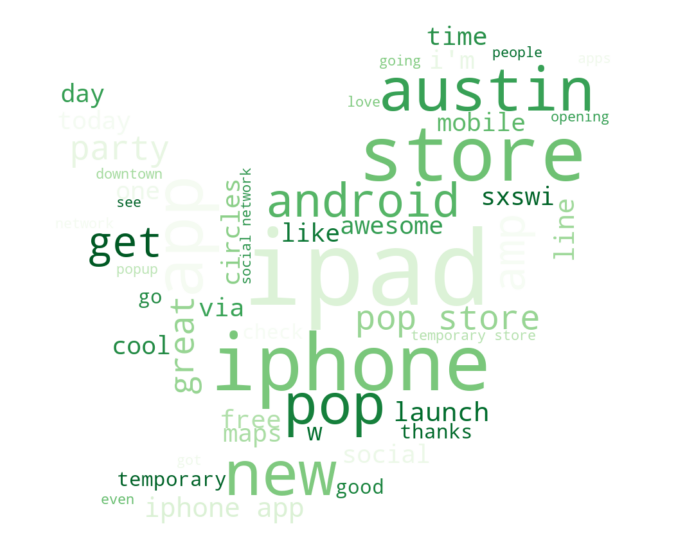

In [78]:
plt.figure(figsize=(15,10))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative Wordcloud

In [79]:
custom_mask = np.array(Image.open("twitter_bw.png"))
neg_cloud = WordCloud(mask=custom_mask, colormap='Reds', background_color="white", max_words=50).generate_from_frequencies(neg_matrix_2.T.sum(axis=1))

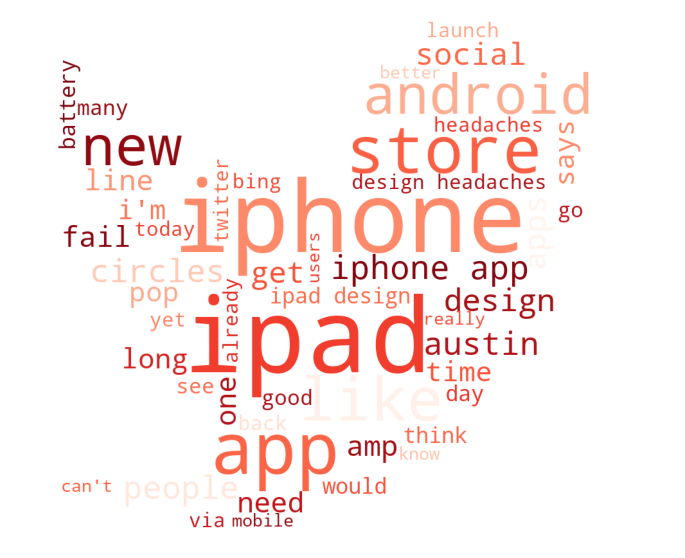

In [80]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(neg_cloud)
plt.axis('off')
plt.show()

## Iteration 6 - Random Forest max_depth adjustments

In [81]:
# Check max_depths of current random forest
[estimator.tree_.max_depth for estimator in rf5.estimators_]

[280,
 243,
 229,
 180,
 265,
 240,
 274,
 231,
 186,
 194,
 250,
 234,
 249,
 271,
 236,
 246,
 269,
 167,
 167,
 200,
 271,
 218,
 219,
 263,
 251,
 244,
 171,
 234,
 183,
 157,
 259,
 255,
 216,
 237,
 291,
 241,
 259,
 151,
 175,
 271,
 146,
 201,
 147,
 225,
 266,
 165,
 280,
 215,
 187,
 247,
 153,
 247,
 184,
 232,
 154,
 195,
 253,
 168,
 174,
 239,
 169,
 259,
 248,
 276,
 249,
 252,
 179,
 234,
 262,
 252,
 147,
 219,
 181,
 218,
 155,
 273,
 224,
 267,
 174,
 284,
 262,
 254,
 253,
 286,
 170,
 226,
 251,
 269,
 203,
 290,
 233,
 257,
 265,
 259,
 230,
 253,
 137,
 182,
 200,
 234,
 280,
 240,
 240,
 226,
 266,
 185,
 268,
 253,
 235,
 221,
 237,
 241,
 156,
 237,
 164,
 219,
 258,
 255,
 260,
 166,
 153,
 244,
 226,
 255,
 246,
 184,
 259,
 205,
 231,
 154,
 290,
 207,
 242,
 184,
 233,
 166,
 255,
 248,
 226,
 243,
 207,
 131,
 182,
 265,
 116,
 239,
 155,
 242,
 226,
 250,
 149,
 226,
 191,
 236,
 220,
 142,
 148,
 204,
 232,
 257,
 274,
 233,
 261,
 266,
 182,
 287,
 234

In [82]:
# grid search for random forest parameters
grid_rf4 = {"n_estimators":[225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [50,100,150,200],
            "min_samples_leaf" : [1],
            "min_samples_split": [3]
            }
GS_rf4 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf4,
    n_jobs=-1,
    verbose=2,
    scoring='recall')

In [83]:
tfidf_6 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5,
                         )
vectorized_6 = tfidf_6.fit_transform(X_train)

In [84]:
GS_rf4.fit(vectorized_6, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:   22.0s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [50, 100, 150, 200],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3], 'n_estimators': [225]},
             scoring='recall', verbose=2)

In [85]:
GS_rf4.best_params_

{'criterion': 'gini',
 'max_depth': 150,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 225}

In [86]:
GS_rf4.best_score_

0.34115743384732533

### Run Final Model on Test Set

In [87]:
test_vec = tfidf_5.transform(X_test)

In [88]:
# Evaluating recall
test_pred = rf5.predict(test_vec)
recall_score(y_test, test_pred)

0.4107142857142857

In [89]:
accuracy_score(y_test, test_pred)

0.8870056497175142

In [90]:
precision_score(y_test, test_pred)

0.7666666666666667

In [91]:
rf5.score(test_vec, y_test)

0.8870056497175142